Data combined successfully.
           coin symbol     price     1h    24h     7d   24h_volume  \
0            0x    ZRX  0.509791  0.025  0.035  0.028   29309302.0   
1            0x    ZRX  0.518160  0.003  0.016 -0.010   24224308.0   
2         1inch  1INCH  1.500000  0.021  0.111  0.163  120457113.0   
3         1inch  1INCH  1.490000  0.008 -0.003  0.087   64145152.0   
4  AIOZ Network   AIOZ  0.237396  0.047  0.287  0.241   13715452.0   

       mkt_cap       date  
0  427933388.0 2022-03-16  
1  439124277.0 2022-03-17  
2  616145134.0 2022-03-16  
3  617505356.0 2022-03-17  
4  114207956.0 2022-03-16  

DataFrame dtypes after preprocessing:
coin                  object
symbol                object
price                float64
1h                   float64
24h                  float64
7d                   float64
24h_volume           float64
mkt_cap              float64
date          datetime64[ns]
dtype: object

Head of feature engineered columns:
           coin  liquidity_ratio

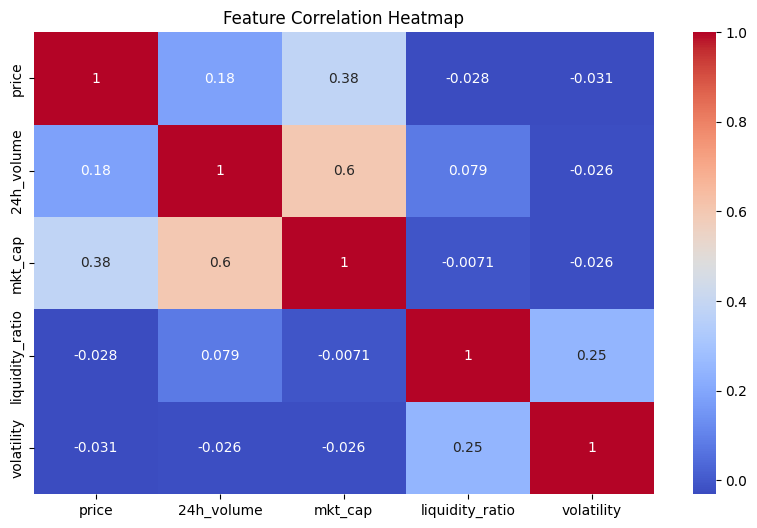


Using features for model: ['price', '1h', '24h', '7d', '24h_volume', 'mkt_cap', 'volatility']

Shape of X after dropping NaNs: (992, 7)
Shape of y after dropping NaNs: (992,)

Shape of X_train: (793, 7)
Shape of X_test: (199, 7)
Shape of y_train: (793,)
Shape of y_test: (199,)
Best Params: {'max_depth': 10, 'n_estimators': 100}

R² Score: 0.37859210842265445
RMSE: 0.37672472953233876

Model saved successfully to crypto_liquidity_model.pkl.
Model file size: 7222175 bytes


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pickle
import os
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# LOAD DATA
df1 = pd.read_csv(r'C:\Users\user\OneDrive\Desktop\IMP\Data\file1.csv')
df2 = pd.read_csv(r'C:\Users\user\OneDrive\Desktop\IMP\Data\file2.csv')

# Combine data
df = pd.concat([df1, df2], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['coin', 'date'], inplace=True)
df.reset_index(drop=True, inplace=True)
print("Data combined successfully.")
print(df.head())

# DATA PREPROCESSING
df.dropna(inplace=True)
for col in ['1h', '24h', '7d']:
    if col in df.columns:
        df[col] = df[col].astype(float)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

print("\nDataFrame dtypes after preprocessing:")
print(df.dtypes)

# FEATURE ENGINEERING
if '24h_volume' in df.columns and 'mkt_cap' in df.columns:
    df['liquidity_ratio'] = df['24h_volume'] / df['mkt_cap']
else:
    print("Warning: '24h_volume' or 'mkt_cap' column not found for liquidity_ratio.")
    if 'liquidity_ratio' not in df.columns:
        df['liquidity_ratio'] = np.nan

if '24h' in df.columns:
    df['volatility'] = df['24h'].abs()
else:
    print("Warning: '24h' column not found for volatility.")
    if 'volatility' not in df.columns:
        df['volatility'] = np.nan

display_cols = [col for col in ['coin', 'liquidity_ratio', 'volatility'] if col in df.columns]
if display_cols:
    print("\nHead of feature engineered columns:")
    print(df[display_cols].head())
else:
    print("Warning: None of the display columns ('coin', 'liquidity_ratio', 'volatility') found.")

# EDA - Heatmap of correlations
heatmap_features = [col for col in ['price', '24h_volume', 'mkt_cap', 'liquidity_ratio', 'volatility'] if col in df.columns]
if len(heatmap_features) > 1:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[heatmap_features].corr(), annot=True, cmap='coolwarm')
    plt.title("Feature Correlation Heatmap")
    plt.show()
else:
    print("Warning: Not enough features available to plot correlation heatmap.")

# MODEL DEVELOPMENT - Random Forest Regressor
features = [col for col in ['price', '1h', '24h', '7d', '24h_volume', 'mkt_cap', 'volatility'] if col in df.columns]
target = 'liquidity_ratio'

if target not in df.columns:
    raise ValueError(f"Error: Target column '{target}' not found in DataFrame.")

X = df[features].select_dtypes(include=np.number)
y = df[target]

features = X.columns.tolist()
if not features:
    raise ValueError("Error: No numeric features available for model training.")

X.dropna(inplace=True)
y = y[X.index]

if X.empty:
    raise ValueError("Error: No data remaining after dropping NaNs for model training.")

print(f"\nUsing features for model: {features}")
print(f"\nShape of X after dropping NaNs: {X.shape}")
print(f"Shape of y after dropping NaNs: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

params = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
grid = GridSearchCV(RandomForestRegressor(), params, cv=3, scoring='r2')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

# MODEL EVALUATION
if len(y_test) > 0:
    print("\nR² Score:", r2_score(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)
else:
    print("Warning: No test data available for model evaluation.")

# SAVE MODEL FOR DEPLOYMENT
try:
    model_filename = "crypto_liquidity_model.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)
    print(f"\nModel saved successfully to {model_filename}.")
    if os.path.exists(model_filename):
        print(f"Model file size: {os.path.getsize(model_filename)} bytes")
except Exception as e:
    print(f"\nError saving model: {e}")